# Features

## Input Data Structure

```json
{
    "metadata": {...}
    "transcription": {
      'full text as string', 
      "segments": [
        {
          "start": 0.0,
          "end": 30.0,
          "text": "...",
          "words": [],
          "speaker": "SPEAKER_00 / SPEAKER_01",
          "speaker_confidence": 0.736
        }
      }
    ]
}
```

Segments happen every 30 seconds. Only classifies one speaker per segment?

In [2]:
import pandas as pd
import numpy as np
import re
import spacy
import os
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from transformers import pipeline
from collections import Counter
from itertools import combinations
import math
import nltk
from nltk.corpus import stopwords
from rapidfuzz import fuzz, process


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset, DatasetDict

from transformers import (RobertaTokenizerFast, 
                          RobertaForSequenceClassification, 
                          TrainingArguments, 
                          Trainer)
from sklearn.metrics import accuracy_score, f1_score


from convokit import PolitenessStrategies

nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")

c:\Users\hofin\anaconda3\envs\podcast\lib\site-packages\triton\knobs.py:212: UserWarning: Failed to find cuobjdump.exe
  warnings.warn(f"Failed to find {binary}")
c:\Users\hofin\anaconda3\envs\podcast\lib\site-packages\triton\knobs.py:212: UserWarning: Failed to find nvdisasm.exe
  warnings.warn(f"Failed to find {binary}")
W1209 20:25:33.452000 1356 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


c:\Users\hofin\anaconda3\envs\podcast\lib\site-packages\convokit\coordination\coordination.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hofin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
file_name = "./diarizations_v0/a_bit_fruity_with_matt_bernstein/whisper_small/transcript_per_show/a_morning_with_vivian_wilson_elons_estranged_daughter_normalized.json"
output_name = "a_morning_with_vivian_wilson_elons_estranged_daughter_normalized.json"

### Total Questions in episode
Regex better than model

In [30]:
#https://huggingface.co/shahrukhx01/question-vs-statement-classifier
# model_name = "shahrukhx01/question-vs-statement-classifier"
# classifier = pipeline("text-classification", model=model_name)

# Function to split full text into sentences
def split_into_sentences(text):
    doc = nlp(text)
    sentences = [sent.text.strip() for sent in doc.sents]
    return sentences

# # Function to classify if a sentence is a question using the model
# def is_question_model(sentence):
#     result = classifier(sentence)
#     label = result[0]['label']
#     score = result[0]['score']
#     has_qmark = bool(re.search(r'\?\s*$', sentence))
#     return (label == "LABEL_1" and score > 0.8) or has_qmark

# Function to classify if a sentence is a question using regex only
def is_question(sentence):
    pattern = r"\?\s*$" 
    return bool(re.search(pattern, sentence))

In [36]:
with open(file_name, "r", encoding="utf-8") as f:
    data = json.load(f)

sentences = split_into_sentences(data["transcription"]["full_text"])

# Total amount of sentences
print(f"Total sentences: {len(sentences)}")

# # Total amount of questions
total_questions = []
# total_questions_model = []

for sentence in sentences:
    if is_question(sentence):
        total_questions.append(sentence)
        
# for sentence in sentences:
#     if is_question_model(sentence):
#         total_questions_model.append(sentence)
        
# missing_in_regex = [q for q in total_questions_model if q not in total_questions]
# print(missing_in_regex)

print(f"Total questions: {len(total_questions)}")

# Ratio 
question_ratio = len(total_questions) / len(sentences) if sentences else 0
print(f"Question ratio: {question_ratio:.2%}")

# Questions per minute
total_duration = data["metadata"]["duration_seconds"]
total_minutes = total_duration / 60
questions_per_minute = len(total_questions) / total_minutes if total_minutes else 0
print(f"Questions per minute: {questions_per_minute:.2f}")


Total sentences: 969
Total questions: 96
Question ratio: 9.91%
Questions per minute: 2.01


### Questions per speaker

30 seconds slices only assign one speaker, if other speaker asks question in same segment it would be wrong assigned. 

In [58]:
def normalize(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text)  # collapse multiple spaces
    return text.strip()


# Sometimes sentences are cut off and split into 2 segments, so I check the previous and next segment
# for the most words of that question in a segment and then just take the label of the speaker for that segment
def get_best_segment_match(question, segments):
    q_words = set(normalize(question).split())

    best_score = 0
    best_seg = None

    for seg in segments:
        seg_words = set(normalize(seg["text"]).split())
        score = len(q_words & seg_words)

        if score > best_score:
            best_score = score
            best_seg = seg

    return best_seg, best_score


question_speaker_dict = {}

for i, question in enumerate(total_questions):
    seg, score = get_best_segment_match(question, data["transcription"]["segments"])

    question_speaker_dict[i] = {
        "question": question,
        "start": seg["start"],
        "end": seg["end"],
        "speaker": seg["speaker"],
        "score": score,
    }


questions_per_speaker_count = {}

for info in question_speaker_dict.values():
    speaker = info["speaker"]
    questions_per_speaker_count[speaker] = (
        questions_per_speaker_count.get(speaker, 0) + 1
    )

print(questions_per_speaker_count)

questions_by_speaker = {}

for idx, entry in question_speaker_dict.items():
    speaker = entry["speaker"]
    question = entry["question"]

    if speaker not in questions_by_speaker:
        questions_by_speaker[speaker] = []

    questions_by_speaker[speaker].append(question)

print(questions_by_speaker)

{'SPEAKER_00': 23, 'SPEAKER_02': 59}
{'SPEAKER_00': ['What do you think is more interesting and impactful, understanding how the universe works at a  fundamental level or understanding how the human mind works?', 'But do you really believe that once we understand the fundamental way the universe works at the  particle level, the forces, we would be able to understand how the mind works?', 'Do you think of the universe as a kind of a computational device?', "So what does it mean that there's now more degrees of freedom as they become more integral?", 'So at which point is most of the entanglement happening?', 'Are we talking about close to the Big Bang?', "What do you think of the thought experiment from Nick Bostrom that we're living in a simulation?", "And so it's a constructive question to ask, how difficult is our real world to simulate?", 'You know, if you were to try to do it yourself, how hard would it be?', 'Okay?', "Right, so that's not useful to think about when you're thinkin

Format for those features (new json, add to existing)? Per episode, expand on overall data (podcast, all podcasts)?

### Turn Taking Patterns

#### Turn Count per Speaker

In [10]:
# Detect how often the speaker changes after segments
# So Segment 1 has Speker 0, Segment 2 has speaker 1 -> One turn
# Then segment 3 and 4 also have Spekaer 1, but segment 5 has speaker 1 -> Second Turn
# Metrics: Count how often this changes (int)
# Did Speaker ask question in the last segment? (bool)

segments = data["transcription"]["segments"]

total_turns = 0
turn_id = 0
turn_object = {}

current_speaker = segments[0]["speaker"]
turn_start_time = segments[0]["start"]
turn_end_time = segments[0]["end"]
turn_text = segments[0]["text"] 

def check_for_question(text):
    sentences = split_into_sentences(text)
    for sentence in sentences:
        if is_question_model(sentence):
            return True
    return False


for i in range(1, len(segments)):
    seg = segments[i]

    if seg["speaker"] == current_speaker:
        # Extend the current turn
        turn_end_time = seg["end"]
        turn_text += " " + seg["text"] 

    else:
        # Speaker changed → close the previous turn
        question_asked = check_for_question(turn_text)
        total_turns += 1

        turn_object[turn_id] = {
            "turn": f"{current_speaker} to {seg['speaker']}",
            "start_time": turn_start_time,
            "end_time": turn_end_time,
            "turn_time_in_seconds": turn_end_time - turn_start_time,
            "question_asked": question_asked,
        }

        # Start a new turn
        turn_id += 1
        current_speaker = seg["speaker"]
        turn_start_time = seg["start"]
        turn_end_time = seg["end"]
        turn_text = seg["text"]

# Close last turn after loop ends
turn_object[turn_id] = {
    "turn": f"{current_speaker} to END",
    "start_time": turn_start_time,
    "end_time": turn_end_time,
    "turn_time_in_seconds": turn_end_time - turn_start_time,
    "question_asked": check_for_question(segments[-1]["text"]),
}

# Plus 1 because we count the first sentence as a turn aswell
print(total_turns + 1)

# for turn_id, turn_info in turn_object.items():
#     print(turn_id, turn_info)
    
print(turn_object)

# Total turns per speaker
turns_per_speaker = {}

for turn_id, turn_info in turn_object.items():
    turn_str = turn_info["turn"]
    speaker_before = turn_str.split(" to ")[0]

    if speaker_before not in turns_per_speaker:
        turns_per_speaker[speaker_before] = 0

    turns_per_speaker[speaker_before] += 1

print(turns_per_speaker)

15
{0: {'turn': 'SPEAKER_06 to SPEAKER_10', 'start_time': 0.0, 'end_time': 30.0, 'turn_time_in_seconds': 30.0, 'question_asked': False}, 1: {'turn': 'SPEAKER_10 to SPEAKER_01', 'start_time': 30.0, 'end_time': 90.0, 'turn_time_in_seconds': 60.0, 'question_asked': False}, 2: {'turn': 'SPEAKER_01 to SPEAKER_10', 'start_time': 90.0, 'end_time': 120.0, 'turn_time_in_seconds': 30.0, 'question_asked': False}, 3: {'turn': 'SPEAKER_10 to SPEAKER_00', 'start_time': 120.0, 'end_time': 210.0, 'turn_time_in_seconds': 90.0, 'question_asked': True}, 4: {'turn': 'SPEAKER_00 to SPEAKER_07', 'start_time': 210.0, 'end_time': 690.0, 'turn_time_in_seconds': 480.0, 'question_asked': True}, 5: {'turn': 'SPEAKER_07 to SPEAKER_05', 'start_time': 690.0, 'end_time': 720.0, 'turn_time_in_seconds': 30.0, 'question_asked': False}, 6: {'turn': 'SPEAKER_05 to SPEAKER_00', 'start_time': 720.0, 'end_time': 780.0, 'turn_time_in_seconds': 60.0, 'question_asked': False}, 7: {'turn': 'SPEAKER_00 to SPEAKER_10', 'start_time

#### Switch Rate and Dominance

In [11]:
#Average switch rate of the conversation
average_switch_time =  total_minutes / total_turns
print(average_switch_time)

#Speaking time per speaker
speaking_time = {}

for seg in segments:
    speaker = seg["speaker"]
    duration = seg["end"] - seg["start"]
    
    if speaker not in speaking_time:
        speaking_time[speaker] = 0.0
        
    speaking_time[speaker] += duration

print(speaking_time)

#Average turn time per Speaker
average_turn_time = {}

for speaker in speaking_time:
    avg_time = speaking_time[speaker] / turns_per_speaker[speaker]
    average_turn_time[speaker] = avg_time

print(average_turn_time)

3.128660714285714
{'SPEAKER_06': 30.0, 'SPEAKER_10': 240.0, 'SPEAKER_01': 30.0, 'SPEAKER_00': 2100.0, 'SPEAKER_07': 60.0, 'SPEAKER_05': 60.0, 'SPEAKER_04': 30.0, 'SPEAKER_UNKNOWN': 78.07999999999993}
{'SPEAKER_06': 30.0, 'SPEAKER_10': 60.0, 'SPEAKER_01': 30.0, 'SPEAKER_00': 525.0, 'SPEAKER_07': 30.0, 'SPEAKER_05': 60.0, 'SPEAKER_04': 30.0, 'SPEAKER_UNKNOWN': 78.07999999999993}


In [12]:
items = sorted(speaking_time.items(), key=lambda x: x[1], reverse=True)
first = items[0]
second = items[1]

print(first)
print(second)

dominance_index = (first[1] - second[1]) / total_duration
print(dominance_index)

('SPEAKER_00', 2100.0)
('SPEAKER_10', 240.0)
0.7077423589509433


#### Vocab Diversity

In [13]:
# Link every sentence to a speaker

sentences_dict = {}
print(data)


for i, sentence in enumerate(sentences, start=0):
    seg, score = get_best_segment_match(sentence, data["transcription"]["segments"])

    sentences_dict[i] = {
        "sentence": sentence,
        "start": seg["start"],
        "end": seg["end"],
        "speaker": seg["speaker"]
    }
    
sentences_per_speaker = {}

for idx, entry in sentences_dict.items(): 
    speaker = entry["speaker"]
    sentence = entry["sentence"]

    if speaker not in sentences_per_speaker:
        sentences_per_speaker[speaker] = []

    sentences_per_speaker[speaker].append(sentence)

print(sentences_per_speaker)

speakers_sorted = sorted(
    sentences_per_speaker.items(),
    key=lambda x: len(x[1]),
    reverse=True
)
top_two = speakers_sorted[:2]
sentences_actual_speakers = { speaker: sents for speaker, sents in top_two }

print(sentences_actual_speakers)

{'metadata': {'original_file': 'outputs/downloads/the_tucker_carlson_show/gina_carano.mp3', 'filename': 'gina_carano.mp3', 'model_used': 'small', 'processing_time_seconds': 564.18, 'timestamp': '2025-11-11T10:11:46.894471', 'file_size_mb': 100.31, 'duration_seconds': 2628.075, 'diarization_timestamp': '2025-11-17T05:51:36.622944', 'diarization_device': 'cuda:0', 'worker_rank': 3}, 'transcription': {'full_text': 'Life is long and weird and the longer it is, the weirder it gets. You may have noticed that. But even by that unchanging standard, Gina Chrono has had a pretty remarkable life packed into a relatively short amount of time. So in 2006, she began as a professional mixed martial arts fighter. In a few years she was starring in big Hollywood films like Fast and Furious. Then in 2019, not that long ago, she got one of the biggest roles for her career. She was on a Disney show called The Mandalorian. In case you didn\'t see it, here she is. Stay back, dropper. Easy. Drop your weapon.

In [14]:
stop_words = set(stopwords.words("english"))

def get_unique_words(text):
    # lowercase and extract alphabetic tokens
    words = re.findall(r"\b[a-zA-Z']+\b", text.lower())
    return set(words)

def get_unique_words_without_stopwords(text):
    words = re.findall(r"\b[a-zA-Z']+\b", text.lower())
    filtered = [w for w in words if w not in stop_words]
    return set(filtered)


# Extract full text of speakers
full_text_per_speaker = {
    speaker: " ".join(sentences) for speaker, sentences in sentences_actual_speakers.items()
}

# compute unique words per speaker (version to work with)
unique_words_per_speaker_raw = {
    speaker: get_unique_words(text) for speaker, text in full_text_per_speaker.items()
}

unique_words_per_speaker_raw_no_stopwords = {
    speaker: get_unique_words_without_stopwords(text) for speaker, text in full_text_per_speaker.items()
}

# make sure it is possible to store in json
unique_words_per_speaker = {
    speaker: list(words) for speaker, words in unique_words_per_speaker_raw.items()
}

unique_words_per_speaker_no_stopwords = {
    speaker: list(words) for speaker, words in unique_words_per_speaker_raw_no_stopwords.items()
}

# Count
unique_words_per_speaker_count = {
    speaker: len(words) for speaker, words in unique_words_per_speaker.items()
}

unique_words_per_speaker_count_no_stopwords = {
    speaker: len(words) for speaker, words in unique_words_per_speaker_no_stopwords.items()
}

# Store results for all pairs
all_words = list(unique_words_per_speaker_raw.values())
shared_all = set.intersection(*all_words)
total_all = set.union(*all_words)

# Same for stopwords
all_words_no_stop = list(unique_words_per_speaker_raw_no_stopwords.values())
shared_all_stop = set.intersection(*all_words_no_stop)
total_all_stop = set.union(*all_words_no_stop)

# Compute global overlap (JACCARD)
words_overlap_percentage_symmetric = len(shared_all) / len(total_all) * 100
words_overlap_percentage_symmetric = round(words_overlap_percentage_symmetric, 2)

# Compute global overlap (JACCARD) Stopwords
words_overlap_percentage_symmetric_stop = len(shared_all_stop) / len(total_all_stop) * 100
words_overlap_percentage_symmetric_stop = round(words_overlap_percentage_symmetric_stop, 2)

# Check by speaker
words_overlap_by_speaker = {}

for speaker, words in unique_words_per_speaker_raw.items():
    others = set().union(
        *[w for spk, w in unique_words_per_speaker_raw.items() if spk != speaker]
    )
    shared = words & others
    overlap_pct = len(shared) / len(words) * 100 if words else 0.0
    words_overlap_by_speaker[speaker] = round(overlap_pct, 2)

print(words_overlap_percentage_symmetric)
print(words_overlap_by_speaker)


# Check by speaker Stopwrods
words_overlap_by_speaker_stop = {}

for speaker, words in unique_words_per_speaker_raw_no_stopwords.items():
    others = set().union(
        *[
            w for spk, w in unique_words_per_speaker_raw_no_stopwords.items()
            if spk != speaker
        ]
    )
    shared = words & others
    overlap_pct = len(shared) / len(words) * 100 if words else 0.0
    words_overlap_by_speaker_stop[speaker] = round(overlap_pct, 2)
    

print(words_overlap_percentage_symmetric_stop)
print(words_overlap_by_speaker_stop)

16.68
{'SPEAKER_00': 17.68, 'SPEAKER_10': 74.71}
11.02
{'SPEAKER_00': 11.75, 'SPEAKER_10': 64.0}


In [15]:
stop_words = set(stopwords.words("english"))

def count_words(text):
    words = re.findall(r"\b[a-zA-Z']+\b", text.lower())
    return len(words)

def count_words_without_stopwords(text):
    words = re.findall(r"\b[a-zA-Z']+\b", text.lower())
    filtered = [w for w in words if w not in stop_words]
    return len(filtered)


total_words_per_speaker = {
    speaker: count_words(text) for speaker, text in full_text_per_speaker.items()
}

total_words_per_speaker_without_stopwords = {
    speaker: count_words_without_stopwords(text) for speaker, text in full_text_per_speaker.items()
}

print(total_words_per_speaker)
print(unique_words_per_speaker_count)

print(total_words_per_speaker_without_stopwords)
print(unique_words_per_speaker_count_no_stopwords)

# RTTR
rttr_per_speaker = {}

for speaker in total_words_per_speaker:
    total = total_words_per_speaker[speaker]
    unique = unique_words_per_speaker_count[speaker]

    if total == 0:
        rttr_per_speaker[speaker] = 0.0
    else:
        rttr_per_speaker[speaker] = unique / math.sqrt(total)


print(rttr_per_speaker)

# No stopwords RTTR
rttr_per_speaker_no_stopwords = {}

for speaker in total_words_per_speaker_without_stopwords:
    total = total_words_per_speaker_without_stopwords[speaker]
    unique = unique_words_per_speaker_count_no_stopwords[speaker]

    if total == 0:
        rttr_per_speaker_no_stopwords[speaker] = 0.0
    else:
        rttr_per_speaker_no_stopwords[speaker] = unique / math.sqrt(total)

print(rttr_per_speaker_no_stopwords)

#LTTR
lttr_per_speaker = {}

for speaker in total_words_per_speaker:
    total = total_words_per_speaker[speaker]
    unique = unique_words_per_speaker_count[speaker]

    if total == 0 or unique == 0:
        lttr_per_speaker[speaker] = 0.0
    else:
        lttr_per_speaker[speaker] = math.log(unique) / math.log(total)

print(lttr_per_speaker)

# No Stopwords LTTR
lttr_per_speaker_no_stopwords = {}

for speaker in total_words_per_speaker_without_stopwords:
    total = total_words_per_speaker_without_stopwords[speaker]
    unique = unique_words_per_speaker_count_no_stopwords[speaker]

    if total == 0 or unique == 0:
        lttr_per_speaker_no_stopwords[speaker] = 0.0
    else:
        lttr_per_speaker_no_stopwords[speaker] = math.log(unique) / math.log(total)


print(lttr_per_speaker_no_stopwords)

{'SPEAKER_00': 6135, 'SPEAKER_10': 643}
{'SPEAKER_00': 1086, 'SPEAKER_10': 257}
{'SPEAKER_00': 2652, 'SPEAKER_10': 287}
{'SPEAKER_00': 953, 'SPEAKER_10': 175}
{'SPEAKER_00': 13.865085170927225, 'SPEAKER_10': 10.135090636417521}
{'SPEAKER_00': 18.505726560593207, 'SPEAKER_10': 10.329923381766717}
{'SPEAKER_00': 0.8014726622709872, 'SPEAKER_10': 0.8581738147763891}
{'SPEAKER_00': 0.8701705640224989, 'SPEAKER_10': 0.9125898407351549}


## Politeness Feature

In [21]:
ps = PolitenessStrategies()

results = []

for q in sentences:
    utt = ps.transform_utterance(q, spacy_nlp=nlp)
    results.append({"text": q, "strategies": utt.meta["politeness_strategies"]})

WEIGHTS = {
    "Bias": -0.219798,
    # Politeness markers
    "Gratitude": 2.11927,
    "Deference": 1.22837,
    "Greeting": 0.77941,
    "Positive": 0.68555,
    "Negative": -1.14790,
    "Please": 1.31409,
    "Please_start": -1.71990,
    "Indirect_(btw)": 1.18813,
    "Hedges": 0.61410,
    "Factuality": -1.04980,
    "Apologizing": 1.50141,
    # Person markers
    "1st_person": 0.27582,
    "1st_person_pl.": 0.21695,
    "1st_person_start": 0.01042,
    "2nd_person": -0.04706,
    "2nd_person_start": -0.43240,
    # Directness
    "Direct_question": -1.18020,
    "Direct_start": -1.54560,
    # Modality
    "Counterfactual_modal": 0.94153,
    "Indicative_modal": 0.35432,
}


FEATURE_MAP = {
    "==Gratitude==": "Gratitude",
    "==Deference==": "Deference",
    "==Indirect_(greeting)==": "Greeting",
    "==HASPOSITIVE==": "Positive",
    "==HASNEGATIVE==": "Negative",
    "==Please==": "Please",
    "==Please_start==": "Please_start",
    "==Indirect_(btw)==": "Indirect_(btw)",
    "==Hedges==": "Hedges",
    "==Factuality==": "Factuality",
    "==Apologizing==": "Apologizing",
    "==1st_person==": "1st_person",
    "==1st_person_pl.==": "1st_person_pl.",
    "==1st_person_start==": "1st_person_start",
    "==2nd_person==": "2nd_person",
    "==2nd_person_start==": "2nd_person_start",
    "==Direct_question==": "Direct_question",
    "==Direct_start==": "Direct_start",
    "==SUBJUNCTIVE==": "Counterfactual_modal",
    "==INDICATIVE==": "Indicative_modal",
}


def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def compute_politeness_score(strategy_dict):
    # Start with the bias term
    z = WEIGHTS["Bias"]

    for feat, val in strategy_dict.items():
        if val == 0:
            continue

        core = feat.replace("feature_politeness_", "")

        for substring, mapped in FEATURE_MAP.items():
            if core.startswith(substring):
                if mapped in WEIGHTS:
                    z += WEIGHTS[mapped] * val
                break

    # Final probability-like politeness score
    return sigmoid(z)



for r in results:
    score = compute_politeness_score(r["strategies"])
    print(f"Text: {r['text']}")
    print(f"Politeness score: {score:.3f}")
    print()

Text: The following is a conversation with Sean Carroll.
Politeness score: 0.445

Text: He's a theoretical physicist at Caltech,  specializing in quantum mechanics, gravity, and cosmology.
Politeness score: 0.445

Text: He's the author of several popular books,  one on the Arrow of Time called From Eternity to Hear,  one on the Higgs Boson called Particle at the End of the Universe,  and one on Science and Philosophy called The Big Picture,  on the origins of life, meaning, and the universe itself.
Politeness score: 0.614

Text: He has an upcoming book on quantum mechanics  that you can pre-order now called Something Deeply Hidden.
Politeness score: 0.434

Text: He writes one of my favorite blogs on his  website, proposterousuniverse.com.
Politeness score: 0.677

Text: I recommend clicking on the greatest hits link that lists  accessible interesting posts on the arrow of time, dark matter, dark energy, the big bang,  general relativity, string theory, quantum mechanics, and the big met

In [20]:
utt.meta["politeness_strategies"]

{'feature_politeness_==Please==': 0,
 'feature_politeness_==Please_start==': 0,
 'feature_politeness_==HASHEDGE==': 0,
 'feature_politeness_==Indirect_(btw)==': 0,
 'feature_politeness_==Hedges==': 0,
 'feature_politeness_==Factuality==': 0,
 'feature_politeness_==Deference==': 0,
 'feature_politeness_==Gratitude==': 0,
 'feature_politeness_==Apologizing==': 0,
 'feature_politeness_==1st_person_pl.==': 0,
 'feature_politeness_==1st_person==': 0,
 'feature_politeness_==1st_person_start==': 0,
 'feature_politeness_==2nd_person==': 0,
 'feature_politeness_==2nd_person_start==': 0,
 'feature_politeness_==Indirect_(greeting)==': 0,
 'feature_politeness_==Direct_question==': 0,
 'feature_politeness_==Direct_start==': 0,
 'feature_politeness_==HASPOSITIVE==': 1,
 'feature_politeness_==HASNEGATIVE==': 0,
 'feature_politeness_==SUBJUNCTIVE==': 0,
 'feature_politeness_==INDICATIVE==': 0}

## Get segment for question

In [51]:
def find_segment_for_sentence(sentence, segments):
    best_idx = None
    best_score = -1
    sent = sentence.lower()

    for i, seg in enumerate(segments):
        seg_text = seg["text"].lower()
        score = fuzz.partial_ratio(sent, seg_text)

        if score > best_score:
            best_score = score
            best_idx = i
    
    return best_idx, best_score

In [61]:
print(questions_by_speaker['SPEAKER_00'])

['What do you think is more interesting and impactful, understanding how the universe works at a  fundamental level or understanding how the human mind works?', 'But do you really believe that once we understand the fundamental way the universe works at the  particle level, the forces, we would be able to understand how the mind works?', 'Do you think of the universe as a kind of a computational device?', "So what does it mean that there's now more degrees of freedom as they become more integral?", 'So at which point is most of the entanglement happening?', 'Are we talking about close to the Big Bang?', "What do you think of the thought experiment from Nick Bostrom that we're living in a simulation?", "And so it's a constructive question to ask, how difficult is our real world to simulate?", 'You know, if you were to try to do it yourself, how hard would it be?', 'Okay?', "Right, so that's not useful to think about when you're thinking about physics the way Nick Bostrom phrases it if  

In [83]:
# -------------------------
# 1. Helper functions
# -------------------------

HOSTS = {
    "HOWARD KURTZ", "CANDY CROWLEY", "SOLEDAD OBRIEN",
    "CAMPBELL BROWN", "WOLF BLITZER", "JOHN KING",
    "DON LEMON", "CAROL COSTELLO", "PIERS MORGAN",
    "FREDRICKA WHITFIELD", "BRIANNA KEILAR", "ARWA DAMON",
    "DAN LOTHIAN", "ED HENRY", "DAVID SHUSTER", "JEFF ZELENY",
    "SUSAN CANDIOTTI", "T.J. HOLMES", "JOE JOHNS",
    "GLORIA BORGER", "RICHARD QUEST", "ELISE LABOTT",
    "KIMBERLY DOZIER", "JENNIFER GRAY", "WILL RIPLEY",
    "SPEAKER_00"        # mark SPEAKER_00 as HOST if desired
}

def speaker_role(name):
    if not name:
        return "GUEST"
    n = str(name).strip().upper()
    return "HOST" if n in HOSTS else "GUEST"


def build_text_with_speakers(question_text, speaker_q, speaker_after):
    role_q = speaker_role(speaker_q)
    role_after = speaker_role(speaker_after)
    return f"<SPK_Q:{role_q}> <SPK_AFTER:{role_after}> {question_text}"


def get_next_sentence_and_speaker(sentence, sentences, segments):
    """Returns (next_sentence, next_speaker) or (None, None)."""
    if sentence not in sentences:
        return None, None

    idx = sentences.index(sentence)
    if idx + 1 >= len(sentences):
        return None, None

    next_sentence = sentences[idx + 1]

    # find segment that best matches next_sentence
    seg_idx, score = find_segment_for_sentence(next_sentence, segments)
    next_speaker = segments[seg_idx]["speaker"]

    return next_sentence, next_speaker


# -------------------------
# 2. Process ALL questions for ALL speakers
# -------------------------

final_inputs = []   # <-- you will get a list of formatted training examples

for speaker, question_list in questions_by_speaker.items():
    for question_text in question_list:

        # Find next sentence + speaker
        next_sentence, next_speaker = get_next_sentence_and_speaker(
            question_text, sentences, segments
        )

        # Build formatted input
        formatted = build_text_with_speakers(
            question_text=question_text,
            speaker_q=speaker,
            speaker_after=next_speaker
        )

        final_inputs.append({
            "question": question_text,
            "speaker_q": speaker,
            "next_sentence": next_sentence,
            "speaker_after": next_speaker,
            "model_input": formatted
        })

# -------------------------
# 3. Print example
# -------------------------

print("Example:")
print(final_inputs[0]["model_input"])


Example:
<SPK_Q:HOST> <SPK_AFTER:GUEST> What do you think is more interesting and impactful, understanding how the universe works at a  fundamental level or understanding how the human mind works?


In [81]:
def predict_question_type(text):
    # Tokenize input
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=256
    )

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred_id = torch.argmax(logits, dim=1).item()

    # Convert class ID → label string
    pred_label = label_encoder.inverse_transform([pred_id])[0]
    return pred_label

In [90]:
def classify_list(questions):
    for q in questions:
        print(f"Q: {q}")
        label = predict_question_type(q)
        print(f"A: {label}\n")


In [96]:
for m in final_inputs[:5]:
    print(m["model_input"])
    label = predict_question_type(m["model_input"])
    print(f"Predicted label: {label}\n")

<SPK_Q:HOST> <SPK_AFTER:GUEST> What do you think is more interesting and impactful, understanding how the universe works at a  fundamental level or understanding how the human mind works?
Predicted label: Deliberative

<SPK_Q:HOST> <SPK_AFTER:GUEST> But do you really believe that once we understand the fundamental way the universe works at the  particle level, the forces, we would be able to understand how the mind works?
Predicted label: Deliberative

<SPK_Q:HOST> <SPK_AFTER:GUEST> Do you think of the universe as a kind of a computational device?
Predicted label: Deliberative

<SPK_Q:HOST> <SPK_AFTER:GUEST> So what does it mean that there's now more degrees of freedom as they become more integral?
Predicted label: Deliberative

<SPK_Q:HOST> <SPK_AFTER:HOST> So at which point is most of the entanglement happening?
Predicted label: ISQ



## Type of Question
4 Types based on this [Paper](https://aclanthology.org/2024.lrec-main.1516/):
- DELIBERATIVE: These questions encourage participants in the conversation to share their perspectives on the topic broached in the question.
- RHETORICAL: Typically, rhetorical questions don’t seek an answer or already imply one. Their primary function is to underscore the speaker’s viewpoint.
- ISQ (Information-Seeking-Question): Designed to obtain factual details from participants.
- OTHER: A category for questions that don’t fit the criteria of the above NISQs labels.
- {0: 'Deliberative', 1: 'ISQ', 2: 'OTHERS', 3: 'Rhetorical'}

They show results for roBERTa model without context (best performance), BigBird (with 2 different scopes of sentences before and after the target sentence)  
  
They used gpt-3.5-turbo with a very long prompt in the structure
- Introduction to task
- Detailed description of each label
- present the task and formulate the question

They claim that the performance might be worse because they did not include speaker information. Including this might boost the performance.  


In [42]:
# Load NISQ dataset
df_nisq = pd.read_csv("./NISQ_dataset/final_train.csv", sep=";")


# As said in the paper, providing the speaker information might improve performance
df_nisq = df_nisq[[
    "index",
    "question",
    "question_speaker",
    "ctx_after1_speaker",
    "label"
]]


df_nisq.head()

,index,question,question_speaker,ctx_after1_speaker,label
0,1,"How did you keep it a secret, that sort of thing?",UNIDENTIFIED MALE,UNIDENTIFIED MALE,Deliberative
1,2,And I talked to the local newspaper editor her...,DAN LOTHIAN,DAN LOTHIAN,OTHERS
2,3,You know what I mean?,PRESS,PRESS,Rhetorical
3,4,And your work has shown that were as polarized...,FRANK SESNO,FRANK SESNO,Rhetorical
4,5,Do journalists focus too much on the first lad...,"KURTZ, HOST (voice-over)","KURTZ, HOST (voice-over)",Deliberative


In [74]:
# speakers = (
#     set(df_nisq["question_speaker"])
#     | set(df_nisq["ctx_before1_speaker"])
#     | set(df_nisq["ctx_after1_speaker"])
#     | set(df_nisq["ctx_before2_speaker"])
#     | set(df_nisq["ctx_after2_speaker"])
# )

# print(sorted(speakers))

HOSTS = {
    "HOWARD KURTZ",
    "CANDY CROWLEY",
    "SOLEDAD OBRIEN",
    "CAMPBELL BROWN",
    "WOLF BLITZER",
    "JOHN KING",
    "DON LEMON",
    "CAROL COSTELLO",
    "PIERS MORGAN",
    "FREDRICKA WHITFIELD",
    "BRIANNA KEILAR",
    "ARWA DAMON",
    "DAN LOTHIAN",
    "ED HENRY",
    "DAVID SHUSTER",
    "JEFF ZELENY",
    "SUSAN CANDIOTTI",
    "T.J. HOLMES",
    "JOE JOHNS",
    "GLORIA BORGER",
    "RICHARD QUEST",
    "ELISE LABOTT",
    "KIMBERLY DOZIER",
    "JENNIFER GRAY",
    "WILL RIPLEY",
    "SPEAKER_00"
}

def speaker_role(name):
    n = name.strip().upper()
    if n in HOSTS:
        return "HOST"
    else:
        return "GUEST"

In [75]:
# def build_text(row):
#     role_q = speaker_role(row["question_speaker"])
#     role_after = speaker_role(row["ctx_after1_speaker"])

#     spk_q = f"<SPK_Q:{role_q}>"
#     spk_after = f"<SPK_AFTER:{role_after}>"

#     return f"{spk_q} {spk_after} {row['question']}"

# df_nisq["text"] = df_nisq.apply(build_text, axis=1)

# Keep only question + label
df_nisq = df_nisq[["question", "label"]]

# Use ONLY the question, no speakers, no context
df_nisq["text"] = df_nisq["question"]


C:\Users\hofin\AppData\Local\Temp\ipykernel_1356\3641715979.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nisq["text"] = df_nisq["question"]


In [76]:
label_encoder = LabelEncoder()
df_nisq["label_id"] = label_encoder.fit_transform(df_nisq["label"])
num_labels = len(label_encoder.classes_)

print("Label mapping:", dict(enumerate(label_encoder.classes_)))

Label mapping: {0: 'Deliberative', 1: 'ISQ', 2: 'OTHERS', 3: 'Rhetorical'}


C:\Users\hofin\AppData\Local\Temp\ipykernel_1356\2727922529.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nisq["label_id"] = label_encoder.fit_transform(df_nisq["label"])


In [77]:
# 80/10/10 split

train_df, temp_df = train_test_split(
    df_nisq,
    test_size=0.20,
    random_state=42,
    stratify=df_nisq["label_id"],
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,  # half of 20% → 10%
    random_state=42,
    stratify=temp_df["label_id"],
)

dataset = DatasetDict(
    {
        "train": Dataset.from_pandas(train_df),
        "validation": Dataset.from_pandas(val_df),
        "test": Dataset.from_pandas(test_df),
    }
)

In [ ]:
import json

# convert HuggingFace Dataset → list of Python dicts
records = dataset["test"].to_list()

# write as a JSON array
with open("test_set.json", "w", encoding="utf-8") as f:
    json.dump(records, f, ensure_ascii=False, indent=2)


In [ ]:
# Load model and tokenizer
model_name = "roberta-large"
tokenizer = RobertaTokenizerFast.from_pretrained(model_name)

# Tokenization
def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=256,
    )

tokenized_dataset = dataset.map(tokenize, batched=True)

# Rename labels
tokenized_dataset = tokenized_dataset.rename_column("label_id", "labels")

# Keep only model inputs
keep = ["input_ids", "attention_mask", "labels"]
tokenized_dataset = tokenized_dataset.remove_columns(
    [c for c in tokenized_dataset["train"].column_names if c not in keep]
)

Map:   0%|          | 0/1206 [00:00<?, ? examples/s]

Map:   0%|          | 0/151 [00:00<?, ? examples/s]

Map:   0%|          | 0/151 [00:00<?, ? examples/s]

In [87]:
# model = RobertaForSequenceClassification.from_pretrained(
#     model_name,
#     num_labels=num_labels
# )

# model.resize_token_embeddings(len(tokenizer))

from transformers import RobertaTokenizer
import joblib

tokenizer = RobertaTokenizer.from_pretrained("./roberta_question_only/")
model = RobertaForSequenceClassification.from_pretrained("./roberta_question_only//")
label_encoder = joblib.load("label_encoder_no_context.pkl")

In [ ]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    matthews_corrcoef,
    confusion_matrix
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    # Confusion matrix
    cm = confusion_matrix(labels, preds)

    return {
        "accuracy": accuracy_score(labels, preds),

        # F1 scores
        "f1_weighted": f1_score(labels, preds, average="weighted"),
        "f1_macro": f1_score(labels, preds, average="macro"),

        # Precision
        "precision_macro": precision_score(labels, preds, average="macro", zero_division=0),
        "precision_weighted": precision_score(labels, preds, average="weighted", zero_division=0),

        # Recall
        "recall_macro": recall_score(labels, preds, average="macro", zero_division=0),
        "recall_weighted": recall_score(labels, preds, average="weighted", zero_division=0),

        # MCC (excellent for imbalanced multi-class datasets)
        "mcc": matthews_corrcoef(labels, preds),

        # Flatten confusion matrix for logging
        # e.g.: cm_0_0, cm_0_1, cm_1_0, ...
        **{f"cm_{i}_{j}": cm[i, j] for i in range(cm.shape[0]) for j in range(cm.shape[1])}
    }


In [ ]:
training_args = TrainingArguments(
    output_dir="./results_eval",
    per_device_eval_batch_size=32,
)

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics
)

results = trainer.evaluate()
print(results)


c:\Users\hofin\anaconda3\envs\podcast\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 1.0140981674194336, 'eval_model_preparation_time': 0.0054, 'eval_accuracy': 0.5695364238410596, 'eval_f1_weighted': 0.5720107706862674, 'eval_f1_macro': 0.4880837912087912, 'eval_precision_macro': 0.49839015151515154, 'eval_precision_weighted': 0.5781657635962272, 'eval_recall_macro': 0.48511029411764706, 'eval_recall_weighted': 0.5695364238410596, 'eval_mcc': 0.3269628161620148, 'eval_cm_0_0': 55, 'eval_cm_0_1': 10, 'eval_cm_0_2': 4, 'eval_cm_0_3': 11, 'eval_cm_1_0': 11, 'eval_cm_1_1': 6, 'eval_cm_1_2': 0, 'eval_cm_1_3': 0, 'eval_cm_2_0': 4, 'eval_cm_2_1': 2, 'eval_cm_2_2': 8, 'eval_cm_2_3': 6, 'eval_cm_3_0': 10, 'eval_cm_3_1': 4, 'eval_cm_3_2': 3, 'eval_cm_3_3': 17, 'eval_runtime': 74.8837, 'eval_samples_per_second': 2.016, 'eval_steps_per_second': 0.067}


In [89]:
import json

with open("test_set.json", "r") as f:
    data = json.load(f)

texts = [d["text"] for d in data]
gold_labels = [d["label"] for d in data]

id2label = {
    0: "Deliberative",
    1: "ISQ",
    2: "OTHERS",
    3: "Rhetorical"
}
label2id = {v: k for k, v in id2label.items()}

def predict_label(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred_id = torch.argmax(logits, dim=1).item()
    return id2label[pred_id]

#pred_labels = [predict_label(t) for t in texts]

from sklearn.metrics import classification_report, confusion_matrix

y_true = [label2id[l] for l in gold_labels]
y_pred = [label2id[p] for p in pred_labels]

print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=list(id2label.values())))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_true, y_pred))

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(y_true, y_pred)
print("MCC:", mcc)


=== Classification Report ===
              precision    recall  f1-score   support

Deliberative       0.69      0.69      0.69        80
         ISQ       0.27      0.35      0.31        17
      OTHERS       0.53      0.40      0.46        20
  Rhetorical       0.50      0.50      0.50        34

    accuracy                           0.57       151
   macro avg       0.50      0.49      0.49       151
weighted avg       0.58      0.57      0.57       151

=== Confusion Matrix ===
[[55 10  4 11]
 [11  6  0  0]
 [ 4  2  8  6]
 [10  4  3 17]]
Accuracy: 0.5695364238410596
MCC: 0.3269628161620148


In [40]:
import joblib
MODEL_PATH = "./roberta_question_only"

tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_PATH)
model = RobertaForSequenceClassification.from_pretrained(MODEL_PATH)
label_encoder = joblib.load("label_encoder_no_context.pkl")

model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=Tru

In [90]:
def classify_batch(questions):
    # Tokenize entire batch
    enc = tokenizer(
        questions,
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors="pt"
    )

    # Move tensors to device (CPU or GPU)
    enc = {k: v.to(model.device) for k, v in enc.items()}

    # Forward pass
    with torch.no_grad():
        logits = model(**enc).logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()

    # Decode predictions
    return label_encoder.inverse_transform(preds)


In [91]:
results = classify_batch(total_questions)

for i, res in enumerate(results):
    print(f"Q: {total_questions[i]}")
    print(f"A: {res}")
    print()

Q: And I'm just curious, like, how are you doing right now?
A: Deliberative

Q: Do you want world peace?
A: Deliberative

Q: Or was my honest answer?
A: Rhetorical

Q: I was also curious, like, what made you decide to not like step into this role?
A: Deliberative

Q: What is with the toad voices today?
A: Rhetorical

Q: And I was like, did this bitch just try to come for me?
A: OTHERS

Q: So you hear this like dumb podcast?
A: ISQ

Q: And how, how was that?
A: ISQ

Q: Did you anticipate the level of support?
A: Deliberative

Q: I'm like what the fuck does that mean?
A: Rhetorical

Q: Were you ever scared of to make your voice so public?
A: Deliberative

Q: So you just celebrated five years of coming out?
A: ISQ

Q: What was your like coming out like?
A: ISQ

Q: What does everyone think about the hunger games?
A: Deliberative

Q: I wish I could have been in your 16 year old brain at the point in which you were strategizing, like, how do I make my coming out less about coming out and mor

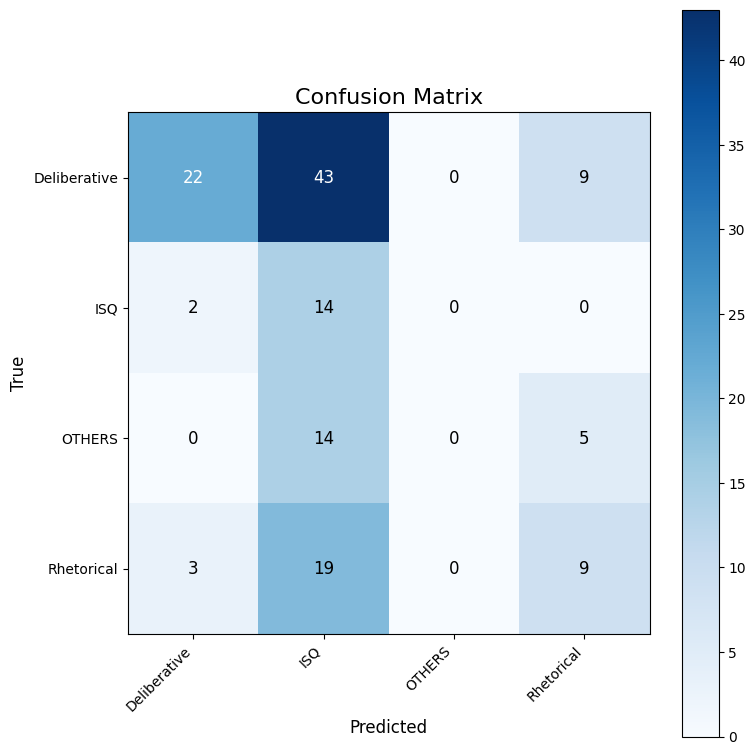


Classification Report:

              precision    recall  f1-score   support

Deliberative       0.81      0.28      0.41        80
         ISQ       0.16      0.82      0.26        17
      OTHERS       0.00      0.00      0.00        20
  Rhetorical       0.39      0.26      0.32        34

   micro avg       0.32      0.30      0.31       151
   macro avg       0.34      0.34      0.25       151
weighted avg       0.54      0.30      0.32       151



c:\Users\hofin\anaconda3\envs\podcast\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\hofin\anaconda3\envs\podcast\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\hofin\anaconda3\envs\podcast\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

In [ ]:

# Load true + predicted labels
with open("test_set.json", "r") as f:
    test_data = json.load(f)

with open("llm_annotations.json", "r") as f:
    llm_data = json.load(f)

true_labels = [x["label"] for x in test_data]
pred_labels = [x["label"] for x in llm_data]

# Define taxonomy order
label_order = ["Deliberative", "ISQ", "OTHERS", "Rhetorical"]

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=label_order)

# --- Plot Confusion Matrix ---
plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)

plt.xticks(np.arange(len(label_order)), label_order, rotation=45, ha="right")
plt.yticks(np.arange(len(label_order)), label_order)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max()/2 else "black",
                 fontsize=12)

plt.colorbar()
plt.tight_layout()
plt.show()

# --- Print Classification Report ---
print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels, labels=label_order))

## Direct/Indirect Address

In [67]:
DIRECT_ADDRESS_RE = re.compile(
    r"""
    (
        # Second-person pronouns
        \b(
            you|your|yours|yourself|
            you['’]re|youre|
            you['’]ll|youll|
            you['’]d|youd|
            you['’]ve|youve
        )\b

      | # Interrogatives + "you" 
        \b(why|what|how|when|where|who|can|could|do|did|will|would|
           are|were|should|have|had|won['’]?t|don['’]?t|is)\b
        [\s,;:—-]+you\b

      | # Imperatives: verb followed by anything
        ^\s*(tell|explain|look|listen|imagine|remember|consider|try|check|answer)\b
    )
    """,
    re.IGNORECASE | re.VERBOSE,
)


def is_direct_address(text):
    return bool(DIRECT_ADDRESS_RE.search(text))

In [92]:
results = []

for s in sentences:
    direct = is_direct_address(s)
    results.append({"text": s, "direct_address": direct})
    
for r in results:
    print(f"Text: {r['text']}")
    print(f"Direct address: {r['direct_address']}\n")


Text: I'm just a human being with a soul.
Direct address: False

Text: I'm just kidding.
Direct address: False

Text: I got my soul so I genuinely removed.
Direct address: False

Text: Hello, hello, and welcome back to A Bit Fruity.
Direct address: False

Text: Today, we have a little bit of a different show.
Direct address: False

Text: This is not usually an interview podcast.
Direct address: False

Text: It's usually a culture and political analysis podcast, but I recently got to know someone who really exists at the center of so many conversations.
Direct address: False

Text: that we have on this podcast but who we have yet to hear from on the fruity podcast mic
Direct address: False

Text: and so I thought now's the time.
Direct address: False

Text: I haven't evaded Matt's place of residence.
Direct address: False

Text: Welcome to the podcast and welcome to my apartment Vivian, Jenna, Wilson.
Direct address: False

Text: Vivian, you have had a whirlwind few months.
Direct addre

## Store All Metrics As Object
Storing all the features in the features object with the format:

```json
"features": {
    "speaking_time_per_speaker": speaking time per speaker in seconds (List, float),
    "dominance_index": Comparing the talking time between both speakers, the higher the value the more one speaker dominates (float)
    "questions": {
        "questions_asked": List of all questions in the episode (Array),
        "questions_total": Amount of total questions asked (int),
        "questions_ratio": Ratio of questions asked compared to total amount of sentences (float),
        "questions_per_minute": Total questions / total time (float),
        "questions_by_speaker": List of all questions in the episode per speaker (array),
        "questions_per_speaker_count": {
            "SPEAKER00": Amount of questions from speaker 1 (int),
            "SPEAKER01": Amount of questions from speaker 2 (int) 
        },
    }, 
    "turn_patterns": {
        "total_turns": Amount of total turns of the conversation (int),
        "total_turns_by_speaker": Amount of total turns by speaker (int),
        "average_switch_time": Average switch time of the speakers in total in minutes (float),
        "average_turn_time_per_speaker": Average time of speaker until next turn in seconds (float),
        "turn_details": {
            "0": { 
                "turn_format": From which speaker to which (SPEAKER_00 to SPEAKER_01 / SPEAKER_01 to SPEAKER_00) (string),
                "turn_time_in_segments": How long the speaker was talking before the turn in segments(int),
                "turn_time_in_seconds": How long the speaker was talking before the turn in seconds (int),
                "question_asked": Was a question asked before the turn? (bool)
            },
            "1": {},
            ...,
        }
    },
    "vocab_diversity": {
        "unique_words_per_speaker": List of unique words each speaker has used during the conversation (string List),
        "unique_words_per_speaker_count": Amount of unique words per speaker (int),
        "words_overlap_symmetric" Percentage of words overlapping between both speakers (float), (How big is the shared vocabulary relative to the whole conversation?)
        "words_overlap_by_speaker": comparing speaker01's unique words to speaker02's unique words and vice versa (List, float percentage) (How much of my vocab is shared by others?),
        "rttr": Root Type-Token Ratio, ratio of unique words to total words len(unique_words) / sqrt(total_words) (float),
        "lttr": Log scaled version, log(len(unique_words)) / log(total_words) (float),
        "words_overlap_symmetric_no_stopwords": Same but no stopwords (float),
        "words_overlap_by_speaker": Same but no stopwords (List, float percentage),
        "rttr_no_stopwords": Same but no stopwords (float),
        "lttr_no_stopwords" Same but no stopwords (float),
        "unique_words_per_speaker_no_stopwords" Same but no stopwords (string List),
        "unique_words_per_speaker_count_no_stopwords" Same but no stopwords (int)
    }
}
```

In [16]:
features = {
    "speaking_time_per_speaker": speaking_time,
    "dominance_index": dominance_index,
    "questions": {
        "questions_asked": total_questions,
        "questions_total": len(total_questions),
        "questions_ratio": question_ratio,
        "questions_per_minute": questions_per_minute,
        "questions_by_speaker": questions_by_speaker,
        "questions_per_speaker_count": questions_per_speaker_count
    },
    "turn_patterns": {
        "total_turns": total_turns,
        "total_turns_by_speaker": turns_per_speaker,
        "average_switch_time": average_switch_time,
        "average_turn_time_per_speaker": average_turn_time,
        "turn_details": turn_object
    },
    "vocab_diversity": {
        "unique_words_per_speaker": unique_words_per_speaker,
        "unique_words_per_speaker:no_stopwords": unique_words_per_speaker_no_stopwords,
        "unique_words_per_speaker_count": unique_words_per_speaker_count,        
        "unique_words_per_speaker_count_no_stopwords": unique_words_per_speaker_count_no_stopwords,
        "words_overlap_symmetric": words_overlap_percentage_symmetric,
        "words_overlap_symmetric_no_stopwords": words_overlap_percentage_symmetric_stop,
        "words_overlap_by_speaker": words_overlap_by_speaker,
        "words_overlap_by_speaker": words_overlap_by_speaker_stop,
        "rttr_per_speaker": rttr_per_speaker,
        "rttr_no_stopwords": rttr_per_speaker_no_stopwords,
        "lttr_per_speaker": lttr_per_speaker,
        "lttr_no_stopwords": lttr_per_speaker_no_stopwords
        
    }
}

with open(output_name, "w", encoding="utf-8") as f:
    json.dump(features, f, indent=4, ensure_ascii=False)